In [190]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import brewer2mpl
from mitgcmdata import MITgcmmodel
from jmd95 import eos
import datetime
import xray as xr
import os 
from tqdm import tqdm

%matplotlib inline
plt.rcParams['image.origin'] = 'bottom'
plt.rcParams['figure.figsize'] = (16,8)


bmap = brewer2mpl.get_map('Set1', 'Qualitative', 6)
plt.rcParams['axes.color_cycle'] = bmap.mpl_colors


In [2]:
ddir = '/data/scratch/rpa/paul_holland_model/paul'

ds = xr.open_dataset(os.path.join(ddir, 'grid.glob.nc'))

for fname in ['state2D-fixed.nc', 'stateExf-fixed.nc',
              'stateTheta-fixed.nc', 'stateSalt-fixed.nc']:
    ds_new = xr.open_dataset(os.path.join(ddir, fname))
    # check if we need to select the top point of a 3D dataset
    if 'DEPTH' in ds_new:
        ds_new = ds_new.sel(DEPTH=5.0)
        ds_new = ds_new.drop('DEPTH')
    # state is 32 bit while grid is 64 bit
    # we can make merging easier by giving them the same coords
    ds_new['X'] = ds.X
    ds_new['Y'] = ds.Y
    ds = ds.merge(ds_new)
ds

<xray.Dataset>
Dimensions:   (TIME: 493, X: 1440, Xp1: 1440, Y: 640, Yp1: 640, Z: 50, Zl: 50, Zp1: 51, Zu: 50)
Coordinates:
  * X         (X) float64 0.125 0.375 0.625 0.875 1.125 1.375 1.625 1.875 ...
  * Y         (Y) float64 -85.91 -85.89 -85.88 -85.86 -85.84 -85.82 -85.8 ...
  * Xp1       (Xp1) float64 0.0 0.25 0.5 0.75 1.0 1.25 1.5 1.75 2.0 2.25 2.5 ...
  * Yp1       (Yp1) float64 -85.92 -85.9 -85.88 -85.87 -85.85 -85.83 -85.81 ...
  * Z         (Z) float64 -5.0 -15.0 -25.0 -35.0 -45.0 -55.0 -65.0 -75.0 ...
  * Zp1       (Zp1) float64 0.0 -10.0 -20.0 -30.0 -40.0 -50.0 -60.0 -70.0 ...
  * Zu        (Zu) float64 -10.0 -20.0 -30.0 -40.0 -50.0 -60.0 -70.0 -80.01 ...
  * Zl        (Zl) float64 0.0 -10.0 -20.0 -30.0 -40.0 -50.0 -60.0 -70.0 ...
  * TIME      (TIME) datetime64[ns] 1971-02-01 1971-03-01 1971-04-01 ...
Data variables:
    Depth     (Y, X) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    dxC       (Y, Xp1) float64 1.982e+03 1.982e+03 1.982e+03 1.982e+03 ...
  

In [3]:
mask = (ds.HFacC[0]==0.0)

In [4]:
diag_names = ['SIarea', 'SIheff', 'SIhsnow', 'SItflux', 'SIatmQnt', 'SIempmr',
             'SIatmFW', 'SIuheff', 'SIvheff', 'TFLUX', 'SFLUX', 'THETA', 'SALT',
             'WTHMASS','WSLTMASS','SIuice','SIvice','SIsnPrcp',
             'SIdHbOCN','SIdSbOCN','SIdHbATO']

In [105]:
print ds.THETA[6].where(~mask).min()
print ds.THETA[6].where(~mask).max()
print ds.SALT[6].where(~mask).min()
print ds.SALT[6].where(~mask).max()



<xray.DataArray ()>
array(-2.244797706604004)
Coordinates:
    TIME     datetime64[ns] 1971-08-01
    Z        float64 -5.0
<xray.DataArray ()>
array(23.77648162841797)
Coordinates:
    TIME     datetime64[ns] 1971-08-01
    Z        float64 -5.0
<xray.DataArray ()>
array(0.0)
Coordinates:
    TIME     datetime64[ns] 1971-08-01
    Z        float64 -5.0
<xray.DataArray ()>
array(40.107872009277344)
Coordinates:
    TIME     datetime64[ns] 1971-08-01
    Z        float64 -5.0


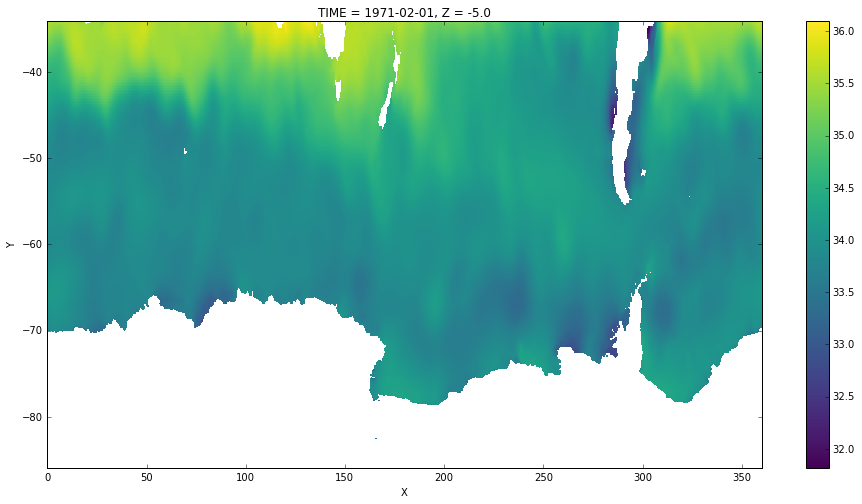

In [6]:
ds.SALT[0].where(~mask)[:-20].plot()

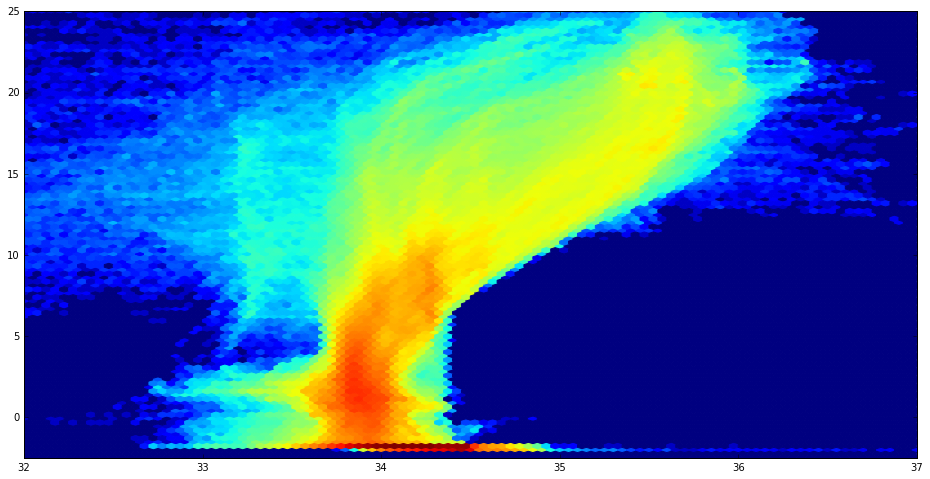

In [7]:
plt.hexbin(ds.SALT[:12].where(~mask).values.ravel(),
           ds.THETA[:12].where(~mask).values.ravel(),
           extent=(32,37,-2.5,25),
           bins='log')

In [318]:
# complicated enough...let's just use linear spacing
#Ntheta = 28*4+1
#theta_levs = np.linspace(-3,25,Ntheta)

Nsalt = 35*2+1
salt_levs = np.linspace(30,37,Nsalt)
dsalt = np.diff(salt_levs)

# this actually doesn't really work great
# dsalt = np.hstack([
#             np.full(15, 0.2, ),
#             np.arange(0.2,0.02,-0.01),
#             np.full(45, 0.02),
#             np.arange(0.02,0.2,0.01),        
#          ])
# salt_levs = 30 + np.cumsum(np.hstack([0,dsalt]))
# Nsalt = len(salt_levs)

In [286]:
dtheta = np.hstack([
            np.full(20, 0.2, ),
            np.arange(0.2,1,0.025),
            np.full(8, 1.0)
         ])
theta_levs = -2.9 + np.cumsum(np.hstack([0,dtheta]))
Ntheta = len(theta_levs)

In [289]:
salt_EvPrRn=0.
rUnit2mass=1.035E+03
HeatCapacity_Cp=3.994E+03

fluxfac_T = 1.0/(HeatCapacity_Cp*rUnit2mass)
fluxfac_S = 1.0/rUnit2mass

# gives m/year
scalefac = 24*60*60*365/1e3

kg_fw_to_m = 1e-3
m_to_kg_fw = 1e3

fw_flux_types = ['IO_plus_AO', 'AI_plus_AO', 'AI', 'AO', 'IO', 'IO_brine', 'IO_melt']

fld_idx = dict()
for n, k in enumerate(fw_flux_types):
    fld_idx[k] = n


In [290]:
import quick_transformation as qt
reload(qt)

<module 'quick_transformation' from 'quick_transformation.pyc'>

In [312]:
Nt = len(ds.TIME)
transformation = np.zeros((Nt, len(fw_flux_types)+4, Ntheta-1, Nsalt-1), 'f8')

#for nmon, niter in tqdm(enumerate(diag_iters)):
for n in tqdm(range(Nt)):

    # just this timestep
    d = ds.isel(TIME=n)

    # freshwater fluxes, evaporation positive
    fw_fluxes = {
      'IO_plus_AO': np.ma.masked_array(d['SIempmr'], mask),
      'AI_plus_AO': -np.ma.masked_array(d['SIatmFW'], mask),
      'SIsnPrcp':  -np.ma.masked_array(d['SIsnPrcp'], mask)
    }
    
    fw_fluxes['AI'] = fw_fluxes['SIsnPrcp']
    fw_fluxes['AO'] = fw_fluxes['AI_plus_AO'] - fw_fluxes['AI']
    fw_fluxes['IO'] = fw_fluxes['IO_plus_AO'] - fw_fluxes['AO']
    # brine rejection
    fw_fluxes['IO_brine'] = np.ma.masked_less(fw_fluxes['IO'].copy(), 0.)
    fw_fluxes['IO_melt'] = np.ma.masked_greater(fw_fluxes['IO'].copy(), 0.)
    
    tflux = np.ma.masked_array(d['oceQnet'], mask)
    
    # has the same units as SFLUX
    salt = d['SALT']
    theta = d['THETA']
    
    tendencies_salt = [ fluxfac_S * fw_fluxes[k].filled(0.) * (salt - salt_EvPrRn)
                        for k in fw_flux_types ]
    tendencies_theta = [ fluxfac_T * tflux, ]
    area = [np.ones_like(tflux), d.SIarea, d.SIheff]
     
    transformation[n] = qt.surface_transformation_rate(
                        ds.rA, salt, salt_levs, theta, theta_levs,
                         fields=(tendencies_theta + tendencies_salt + area))
        

In [315]:
transformation = np.array(transformation)
# bins give the bounds, need the centers
salt_levs_c = 0.5*(salt_levs[1:] + salt_levs[:-1])
theta_levs_c = 0.5*(theta_levs[1:] + theta_levs[:-1])

In [317]:
len(delta_salt)

NameError: name 'delta_salt' is not defined

In [319]:
# get names of variables
transformation_labels = (['heat_flux'] +
    ['salt_' + fwft for fwft in fw_flux_types] )
# now hack on the area stuff
transformation_labels += ['surface_area', 'seaice_area', 'seaice_volume']


# just turn it all to an xray dataset
deltaTclock = 900
time = ds.TIME.values
ds_out = xr.Dataset(coords={'salt': salt_levs_c, 'theta': theta_levs_c, 'time': time})

# add grid density info
ds_out['delta_salt'] = xr.DataArray(dsalt, coords=[salt_levs_c], dims=('salt'))
ds_out['delta_theta'] = xr.DataArray(dtheta, coords=[theta_levs_c], dims=('theta'))
ds_out['delta_salt_theta'] = ds_out.delta_salt * ds_out.delta_theta


for n in range(len(transformation_labels)):
    ds_out[transformation_labels[n]] = xr.DataArray(transformation[:,n],
                        coords=[time, theta_levs_c, salt_levs_c],
                        dims=('time', 'theta', 'salt'))    
#     ds_out['surface_area'] = xr.DataArray(transformation[:,-1],
#                             coords=[time, theta_levs_c, salt_levs_c],
#                             dims=('time', 'theta', 'salt'))

ds_out.to_netcdf('../data/wmt_surface_TS_PAUL.nc')
ds_out

<xray.Dataset>
Dimensions:           (salt: 70, theta: 60, time: 493)
Coordinates:
  * theta             (theta) float64 -2.8 -2.6 -2.4 -2.2 -2.0 -1.8 -1.6 ...
  * salt              (salt) float64 30.05 30.15 30.25 30.35 30.45 30.55 ...
  * time              (time) datetime64[ns] 1971-02-01 1971-03-01 1971-04-01 ...
Data variables:
    delta_salt        (salt) float64 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 ...
    delta_theta       (theta) float64 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 ...
    delta_salt_theta  (salt, theta) float64 0.02 0.02 0.02 0.02 0.02 0.02 ...
    heat_flux         (time, theta, salt) float64 0.0 0.0 0.0 0.0 0.0 0.0 ...
    salt_IO_plus_AO   (time, theta, salt) float64 0.0 0.0 0.0 0.0 0.0 0.0 ...
    salt_AI_plus_AO   (time, theta, salt) float64 0.0 0.0 0.0 0.0 0.0 0.0 ...
    salt_AI           (time, theta, salt) float64 0.0 0.0 0.0 0.0 0.0 0.0 ...
    salt_AO           (time, theta, salt) float64 0.0 0.0 0.0 0.0 0.0 0.0 ...
    salt_IO           (time, theta, sal

In [ ]:
np.log10(ds_out.surface_area.mean(dim='time')).plot(vmin=9, vmax=13, extend='max')

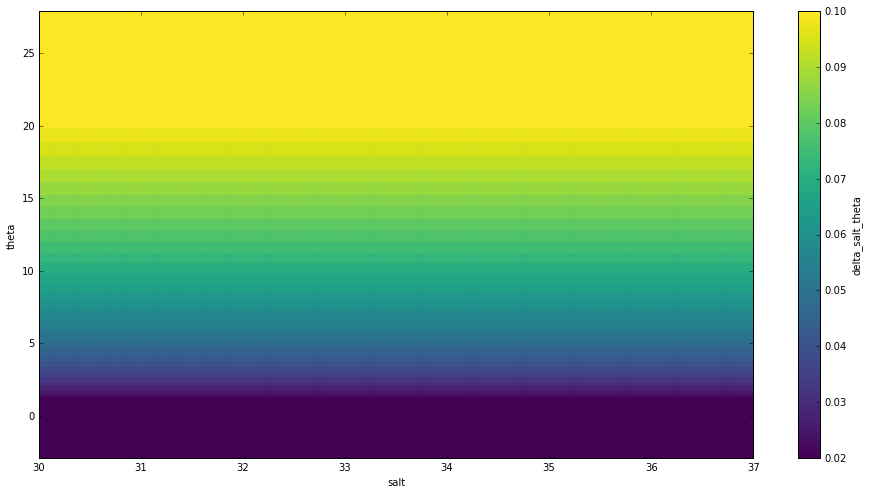

In [321]:
ds_out.delta_salt_theta.T.plot()

(-2.5, 5)

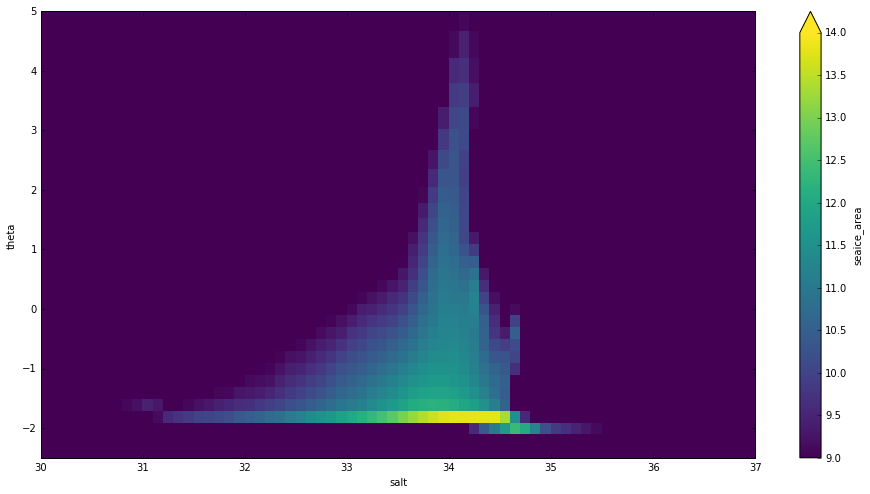

In [320]:
np.log10(ds_out.seaice_area.mean(dim='time')).plot(vmin=9, vmax=14, extend='max')
plt.ylim([-2.5,5])

(-2.5, 5)

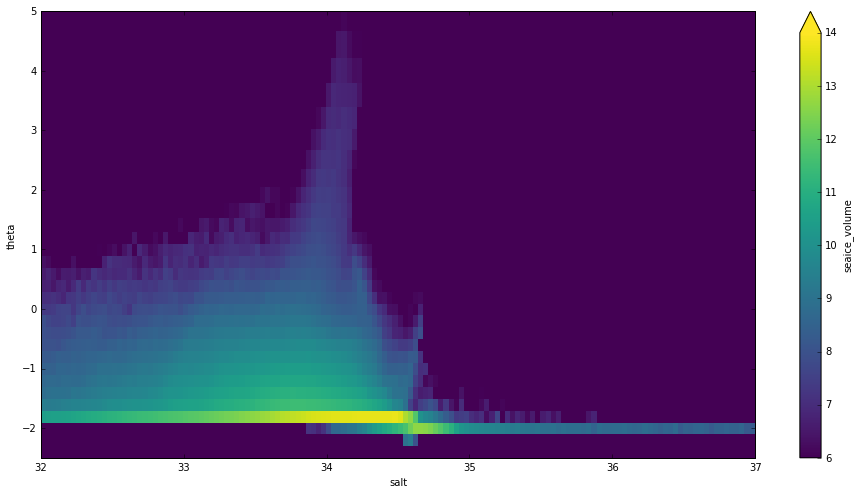

In [252]:
np.log10(ds_out.seaice_volume.mean(dim='time')).plot(vmin=6, vmax=14, extend='max')
plt.ylim([-2.5,5])

(-2.5, 1)

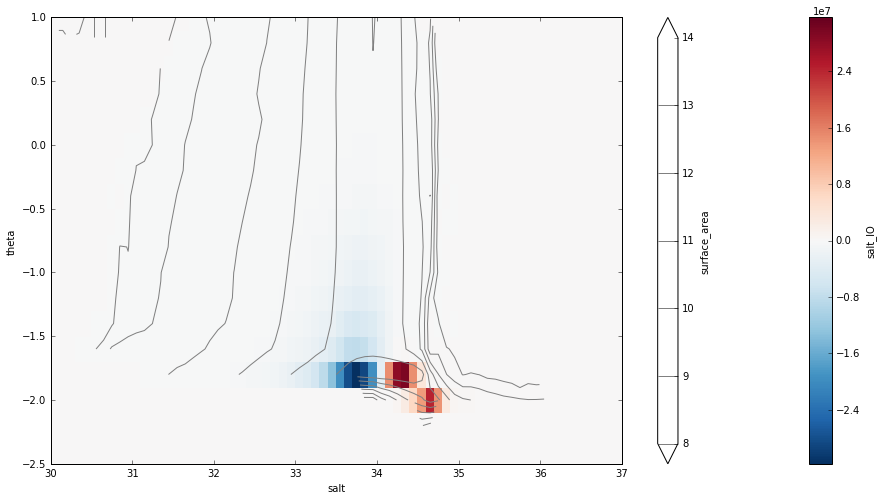

In [322]:
ds_out.salt_IO.mean(dim='time').plot()
np.log10(ds_out.surface_area.mean(dim='time')).plot.contour(vmin=8, vmax=14, extend='both', colors='0.5')
plt.ylim([-2.5,1])

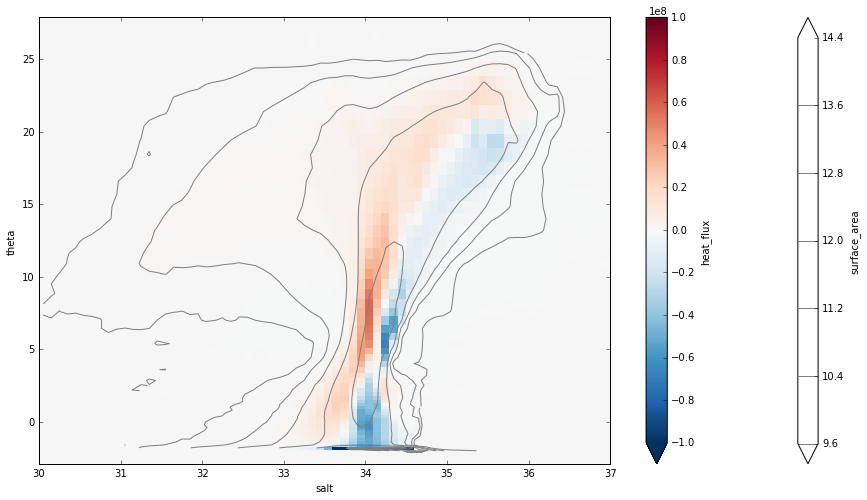

In [323]:
np.log10(ds_out.surface_area.mean(dim='time')).plot.contour(vmin=10, vmax=14, extend='both', colors='0.5')
ds_out.heat_flux.mean(dim='time').plot(vmax=1e8)


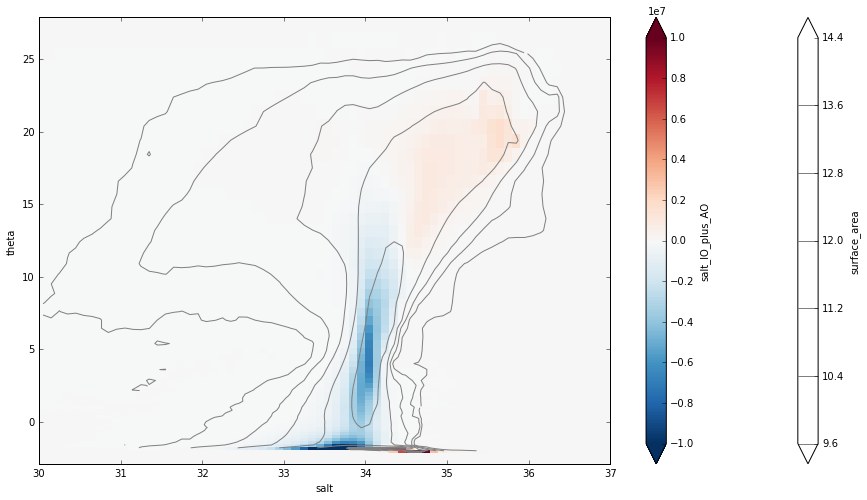

In [324]:
np.log10(ds_out.surface_area.mean(dim='time')).plot.contour(vmin=10, vmax=14, extend='both', colors='0.5')
ds_out.salt_IO_plus_AO.mean(dim='time').plot(vmax=1e7)


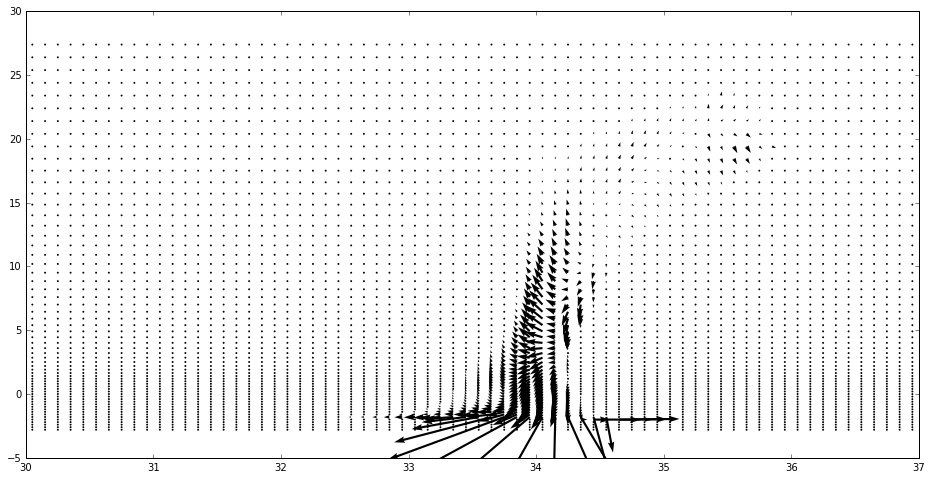

In [325]:
plt.quiver(ds_out.salt, ds_out.theta,
           ds_out.salt_IO_plus_AO.mean(dim='time'),
           ds_out.heat_flux.mean(dim='time'),
           angles='xy', scale_units='xy', scale=5e7
           )

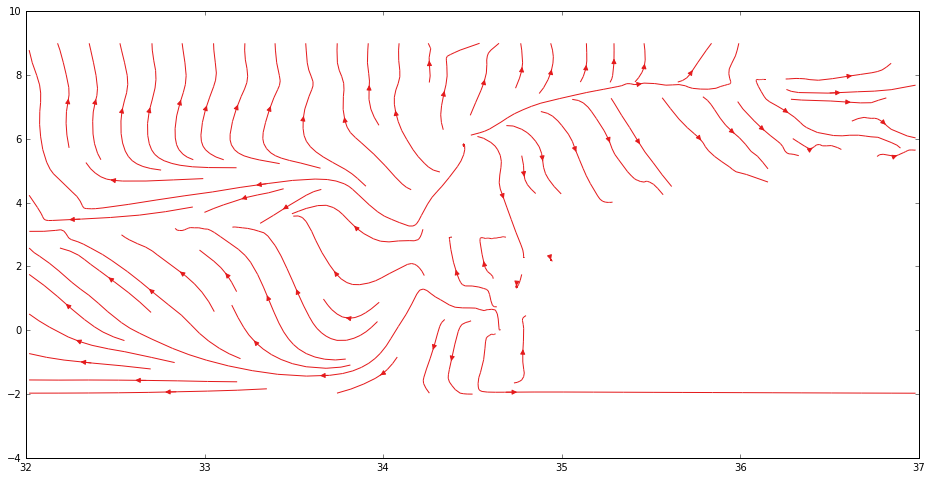

In [267]:
plt.streamplot(ds_out.salt.values, ds_out.theta.values,
           ds_out.salt_IO_plus_AO.mean(dim='time').values,
           ds_out.heat_flux.mean(dim='time').values
           )

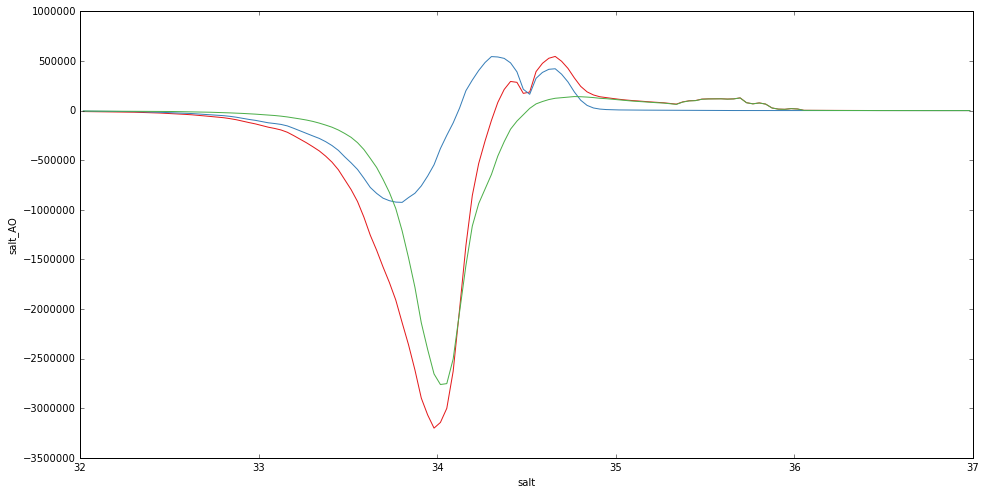

In [263]:
ds_out.salt_IO_plus_AO.mean(dim=['time','theta']).plot()
ds_out.salt_IO.mean(dim=['time','theta']).plot()
ds_out.salt_AO.mean(dim=['time','theta']).plot()


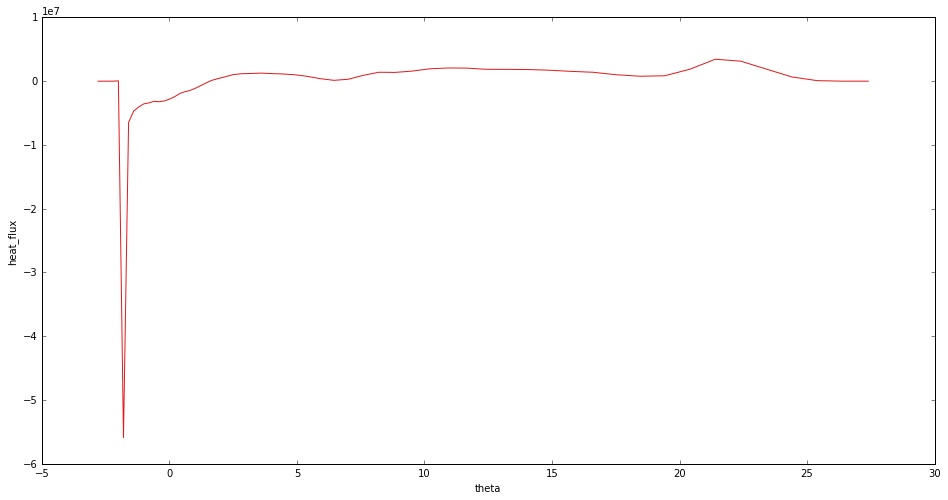

In [264]:
ds_out.heat_flux.mean(dim=['time', 'salt']).plot()